<h1>Coding Session #1</h1>

Diese Datei ist ein Jupyter Notebook. Dieses besteht aus Textblöcken im Markdown Format und ausführbaren Code-Zellen. Diese erkennen Sie an dem kleinen Pfeilsymbol links daneben.

Führen Sie bitte als erstes folgende Zelle aus, um sicherzustellen, dass die benötigten Bibliotheken installiert sind:

In [2]:
!pip install -r requirements.txt

## 1 Lineare Regression

### 1.1 Motivation

Künstliche Neuronale Netze bestehen aus einer Vielzahl an Neuronen. Jedes Neuron ist in der Lage, eine simple mathematische Repräsentation zu lernen. Durch Verknüpfung mehrerer Neuronen können komplexe mathematische Funktionen nachgebildet werden. So kommen neuronale Netze in bspw. in der Bildverarbeitung, der Spracherkennung, für Wetter-, Energiebedarfs- oder Verschleißsprognosen zum Einsatz.

### 1.2 Ziel

Das Grundprinzip eines jeden Neurons ist **lineare Regression**. In diesem Coding Beispiel wird vorerst die Funktionsweise eines einzelnen Neurons betrachtet, bevor mehrere Neuronen zu einem neuronalen Netz verknüpft werden, um dessen Funktionsweise zu verdeutlichen.

### 1.3 Vorbereitung

Bei dieser Datei (`*.ipynb`) handelt sich um ein Jupyter Notebook. Das ist eine interaktive Datei, in der neben strukturierten Textzellen (`markdown`) Codezellen direkt integriert und ausgeführt werden können. Die Verwendung von `Visual Studio Code` wird empfohlen.

**1. Requirements installieren**<br>

Zur Vorbereitung stellen Sie bitte sicher, dass alle benötigten Bibliotheken installiert sind, indem Sie im Terminal folgenden Befehl ausführen:<br>

```pip install -r requirements.txt```

**2. Jupyter Extension installieren**
- Klicken Sie auf Extensions<br>
<img src="images/vscode_extensions.png" width="300px"></img>
- Suchen Sie nach "Jupyter" und installieren Sie die Erweiterung.<br>
<img src="images/install_jupyter.png" width="500px"></img>

### 1.4 Code

**Daten Generierung**

Zuerst wird die Bibliothek `Numpy` importiert, welche fundamentale Funktionalitäten für numerische Berechnungen in Python bereitstellt.

Anschließend werden Beispieldaten generiert. Dafür wird die vorgefertigte Funktion `generate_linear_data` aus der Datei `utilities/data.py` importiert und aufgerufen. Diese generiert Daten, die einer linearen Funktion $y=m\cdot x+n$ folgen, wobei `m` der Anstieg, `n` die y-Verschiebung und `num_samples` die Anzahl der generierten Datenpunkte ist.

Die vorgefertigten Funktionen `plot_data_points` und `plot_series` werden aus der Datei `utilities/visualization.py` importiert. Diese dienen der Visualisierung der Daten.

In [ ]:
import numpy as np                                                  # Numpy is a fundamental package for numerical computations in Python
from utilities.data import generate_linear_data                     # Custom module for generating linear data
from utilities.visualization import plot_data_points, plot_series   # Custom module for visualizing 2D 

X, Y = generate_linear_data(
    m           = 1,
    n           = 0,
    num_samples = 20
)
plot_data_points(X, Y)

Der Parameter `noise` fügt zufällig künstlich generiertes Rauschen zu den Daten hinzu. Da reale Daten meist nicht perfekt sind, wird dieses Rauschen hier durch Zufallswerte simuliert:

In [ ]:
X, Y = generate_linear_data(
    m           = 1.0,
    n           = 0.0,
    num_samples = 50,
    noise       = 0.15
)
plot_data_points(X, Y)

**Lineare Regression**

Das Ziel neuronaler Netze ist es, eine Funktion zu finden, die die Daten möglichst gut repräsentiert. Wir starten hier eine einfache lineare Abhängigkeit durch eine lineare Regression zu approximieren. Das ist genau das, was in einem einzelnen Neuron passiert.

**1. Daten generieren**

Zuerst wird der Datensatz generiert $D=(X,Y)$:

&nbsp;&nbsp;&nbsp;$X$ ...Eingabedaten<br>
&nbsp;&nbsp;&nbsp;$Y$ ...Zieldaten $\to$ es soll gelernt werden, diese Daten in Abhängigkeit von $X$ vorherzusagen

In [ ]:
m           = 0.7   # Anstieg der Geraden
n           = 1.5   # y-Verschiebung der Geraden
noise       = 0.1   # Rauschanteil

X, Y = generate_linear_data(
    num_samples     = 50,
    m               = m,
    n               = n,
    noise           = noise
)

plot_data_points(input=X, target=Y, prediction=None, title=f"Linear Data with noise")

**2. Lineare Regression**

Nun versuchen wir die Funktion $\hat{y}=w\cdot x+b$ so zu optimieren, dass sie die Daten möglichst gut abbildet. Dafür werden mittels **Gradient Descent Algorithmus** die freien Parameter $w$ und $b$ iterativ angepasst.

&nbsp;&nbsp;&nbsp;$x$ ...x-Wert aus den Daten (`inputs`)<br>
&nbsp;&nbsp;&nbsp;$y$ ...y-Wert aus den Daten (`targets`)<br>
&nbsp;&nbsp;&nbsp;$w$ ...weight (zu lernender Anstieg, unbekannt)<br>
&nbsp;&nbsp;&nbsp;$b$ ...bias (zu lernende y-Verschiebung, unbekannt)

> ---
> **Gradient Descent Algorithmus**
> 
> ---
>
> **Eingaben:**
> - Lernrate $\eta$ (eta)
> - Trainingsdaten $D = {(X,Y)}$
> - Anzahl Epochen $E$
> - Initiales weight $w\leftarrow 0$
> - Initialer Bias $b\leftarrow 0$
>
> **Ausgaben**
> - Vorhersage $Y$
> 
> **for** $epoch = 1,\,...,\,E$ **do**<br>
>> **for** $x_i,y_i\in D$ **do**<br>
>>> $\hat{y_i} = w\cdot x_i + b$<br>
>>> $dw = 2 \cdot (y_i-\hat{y_i}) \cdot x_i$<br>
>>> $db = 2 \cdot (y_i-\hat{y_i})$
>>>
>>> $w\leftarrow w - \eta \cdot dw$<br>
>>> $b\leftarrow b - \eta \cdot db$
>>
>> **end for**
>
> **end for**
>
> ---

**Erklärung**

Die lineare Regression minimiert die Summe der quadrierten Abweichungen zwischen tatsächlichen Werten $\hat{y}$ und vorhergesagten Werten $y$, indem sie den quadratischen Fehler (Mean Square Error - MSE) minimiert.
$$L_{MSE}=(y-\hat{y})^2$$
$$L_{MSE}=(y-(wx+b))^2$$

Man startet mit zufälligen Parametern weight $w$ und bias $b$ und verbessert sie in kleinen Schritten, indem man die partielle Ableitung der Loss-Funktion nach $w$ und $b$ bildet und diese multipliziert mit der Lernrate $\eta$ auf $w$ bzw. $b$ addiert:
$$w \leftarrow w - \eta \frac{\partial Loss}{\partial w}$$
$$b \leftarrow b - \eta \frac{\partial Loss}{\partial b}$$

Die partiellen Ableitungen der MSE-Loss-Funktion sind hierbei
$$\frac{\partial L_{MSE}}{\partial w}=2\cdot(wx+b-y)\cdot x=2\cdot(\hat{y}-y)\cdot x$$
$$\frac{\partial{L_{MSE}}}{\partial{b}}=2\cdot(wx+b-y)=2\cdot(\hat{y}-y)$$

In [ ]:
# Initialize parameters
EPOCHS      = 200       # Number of training epochs
LR          = 0.001     # Learning Rate
w, b        = 0., 0.    # weight and bias
losses      = []        # to store loss values

for epoch in range(EPOCHS):
    # prediction is a vector of target size, initialized with zeros
    Y_hat = np.zeros_like(Y)

    for i, (x, y) in enumerate(zip(X, Y)):
        y_hat = w * x + b  # Linear model prediction

        grad_w = 2 * (y_hat - y) * x
        grad_b = 2 * (y_hat - y)

        w -= LR * grad_w
        b -= LR * grad_b

        Y_hat[i] = y_hat

    loss = np.mean((Y_hat - Y) ** 2)
    losses.append(loss)

    if (epoch+1) % 20 == 0 or epoch == 0 or epoch == EPOCHS - 1:
        plot_data_points(input=X, target=Y, prediction=Y_hat, title=f"Linear Data Fitting - Epoch {epoch+1}")
        print(f"Epoch {epoch+1}/{EPOCHS}, MSE: {loss:0.6f}")

plot_series(data=losses, title="Training Loss over Epochs", xlabel="Epochs", ylabel="MSE Loss")
print(f'Learned parameters: w = {w.flatten()[0]:.4f}, b = {b.flatten()[0]:.4f}, True parameters: m = {m}, n = {n}')


Sie haben nun gelernt, wie ein einzelnes Neuron lernt. In Part 2 werden wir uns anschauen, wie dies in einem neuronalen Netz funktioniert.

## 2 Neuronales Netz



In [ ]:
import numpy as np

class Module:
    def forward(self, input):
        raise NotImplementedError

    def backward(self, grad_output, eta = None):
        raise NotImplementedError
    
class DenseLayer(Module):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * 0.1
        self.biases = np.zeros((1, output_size))
    
    def forward(self, input):
        self.input = input.copy()
        return np.dot(input, self.weights) + self.biases
    
    def backward(self, grad_output, eta):
        grad_input = np.dot(grad_output, self.weights.T)
        grad_weights = np.dot(self.input.T, grad_output)
        grad_biases = np.sum(grad_output, axis=0, keepdims=True)
        
        # Update weights and biases
        self.weights -= eta * grad_weights
        self.biases -= eta * grad_biases
        
        return grad_input
    
class ReLU(Module):
    def forward(self, input):
        self.input = input
        return np.maximum(0, input)
    
    def backward(self, grad_output):
        grad_input = grad_output.copy()
        grad_input[self.input <= 0] = 0
        return grad_input
    
class MSELoss:
    def forward(self, prediction, target):
        self.prediction = prediction
        self.target = target
        return np.mean((prediction - target) ** 2)
    
    def backward(self, prediction, target):
        return 2 * (prediction - target) / target.size
    
class NeuralNetwork(Module):
    def __init__(
            self,
            layers:list[Module]
    ):
        self.layers = layers

    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input
    
    def backward(self, grad_output, eta):
        for layer in reversed(self.layers):
            if isinstance(layer, DenseLayer):
                grad_output = layer.backward(grad_output, eta)
            else:
                grad_output = layer.backward(grad_output)
        return grad_output

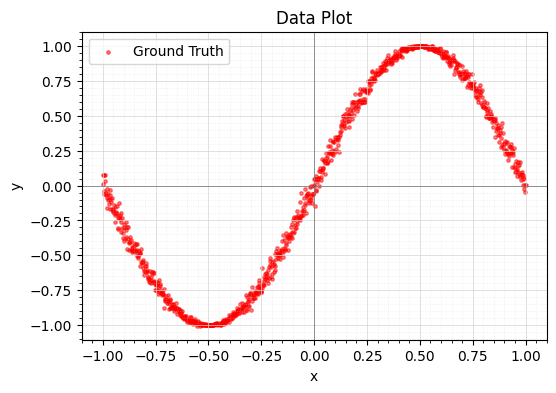

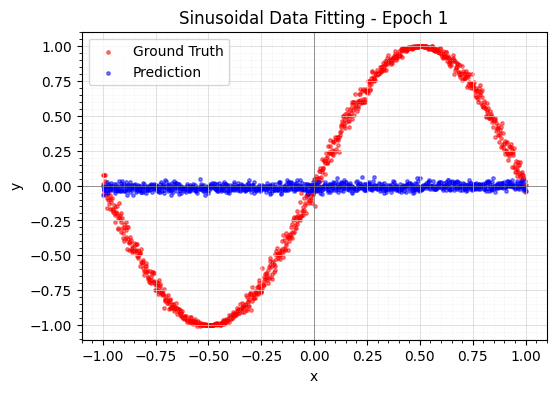

Epoch 1/100, MSE: 0.495366
Epoch 2/100, MSE: 0.477245
Epoch 3/100, MSE: 0.387067
Epoch 4/100, MSE: 0.154682
Epoch 5/100, MSE: 0.102221
Epoch 6/100, MSE: 0.097050
Epoch 7/100, MSE: 0.092785
Epoch 8/100, MSE: 0.090079
Epoch 9/100, MSE: 0.087448


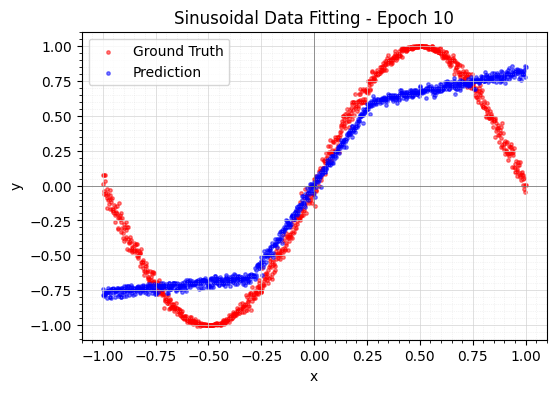

Epoch 10/100, MSE: 0.084327
Epoch 11/100, MSE: 0.081735
Epoch 12/100, MSE: 0.078608
Epoch 13/100, MSE: 0.076188
Epoch 14/100, MSE: 0.073085
Epoch 15/100, MSE: 0.069853
Epoch 16/100, MSE: 0.067134
Epoch 17/100, MSE: 0.063850
Epoch 18/100, MSE: 0.060139
Epoch 19/100, MSE: 0.056253


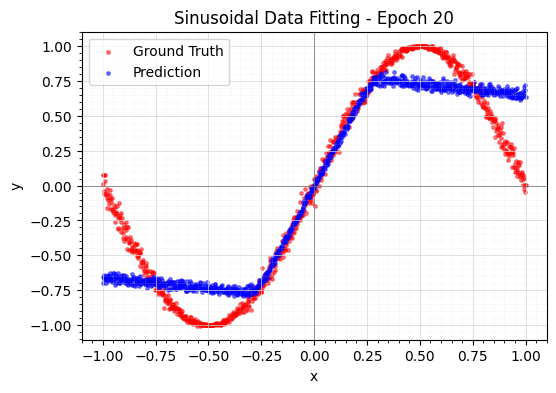

Epoch 20/100, MSE: 0.052377
Epoch 21/100, MSE: 0.047828
Epoch 22/100, MSE: 0.043813
Epoch 23/100, MSE: 0.039023
Epoch 24/100, MSE: 0.034766
Epoch 25/100, MSE: 0.030468
Epoch 26/100, MSE: 0.026389
Epoch 27/100, MSE: 0.022560
Epoch 28/100, MSE: 0.019036
Epoch 29/100, MSE: 0.016094


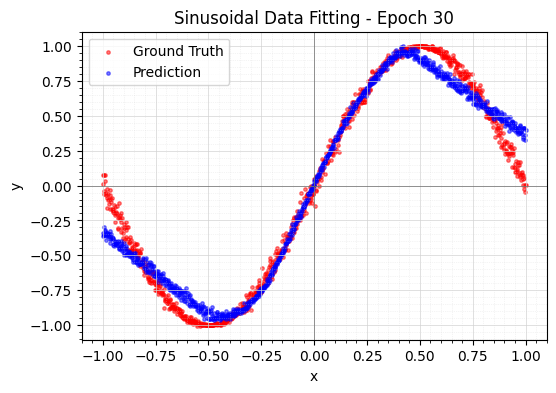

Epoch 30/100, MSE: 0.013491
Epoch 31/100, MSE: 0.011114
Epoch 32/100, MSE: 0.009413
Epoch 33/100, MSE: 0.007732
Epoch 34/100, MSE: 0.006565
Epoch 35/100, MSE: 0.005577
Epoch 36/100, MSE: 0.004752
Epoch 37/100, MSE: 0.004173
Epoch 38/100, MSE: 0.003648
Epoch 39/100, MSE: 0.003297


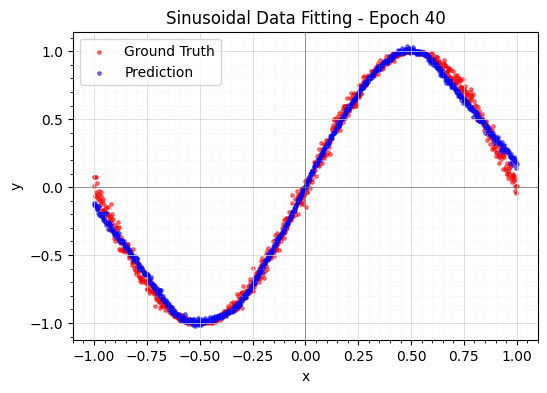

Epoch 40/100, MSE: 0.003020
Epoch 41/100, MSE: 0.002767
Epoch 42/100, MSE: 0.002563
Epoch 43/100, MSE: 0.002353
Epoch 44/100, MSE: 0.002266
Epoch 45/100, MSE: 0.002165
Epoch 46/100, MSE: 0.002070
Epoch 47/100, MSE: 0.001969
Epoch 48/100, MSE: 0.001917
Epoch 49/100, MSE: 0.001822


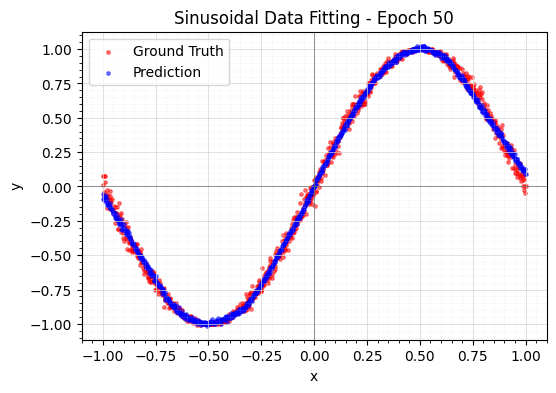

Epoch 50/100, MSE: 0.001741
Epoch 51/100, MSE: 0.001742
Epoch 52/100, MSE: 0.001680
Epoch 53/100, MSE: 0.001666
Epoch 54/100, MSE: 0.001611
Epoch 55/100, MSE: 0.001571
Epoch 56/100, MSE: 0.001569
Epoch 57/100, MSE: 0.001531
Epoch 58/100, MSE: 0.001527
Epoch 59/100, MSE: 0.001524


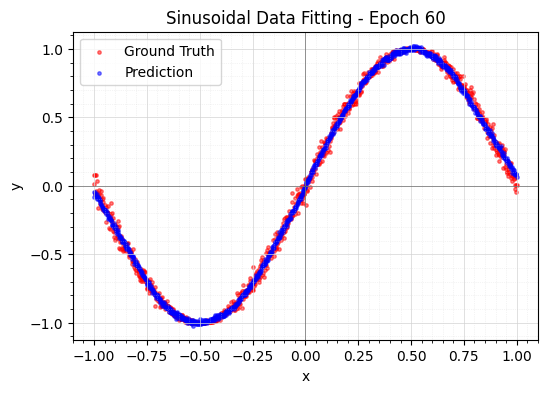

Epoch 60/100, MSE: 0.001490
Epoch 61/100, MSE: 0.001483
Epoch 62/100, MSE: 0.001459
Epoch 63/100, MSE: 0.001444
Epoch 64/100, MSE: 0.001446
Epoch 65/100, MSE: 0.001421
Epoch 66/100, MSE: 0.001426
Epoch 67/100, MSE: 0.001406
Epoch 68/100, MSE: 0.001390
Epoch 69/100, MSE: 0.001375


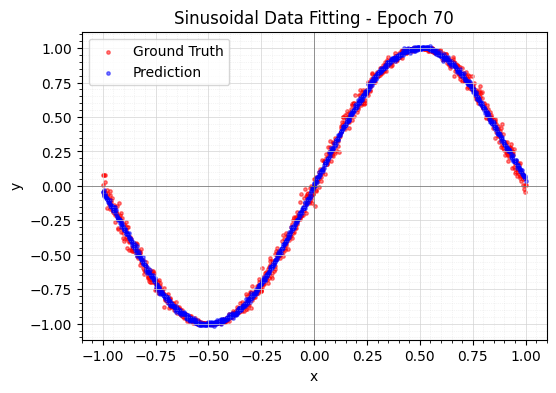

Epoch 70/100, MSE: 0.001360
Epoch 71/100, MSE: 0.001391
Epoch 72/100, MSE: 0.001399
Epoch 73/100, MSE: 0.001360
Epoch 74/100, MSE: 0.001354
Epoch 75/100, MSE: 0.001350
Epoch 76/100, MSE: 0.001346
Epoch 77/100, MSE: 0.001358
Epoch 78/100, MSE: 0.001372
Epoch 79/100, MSE: 0.001336


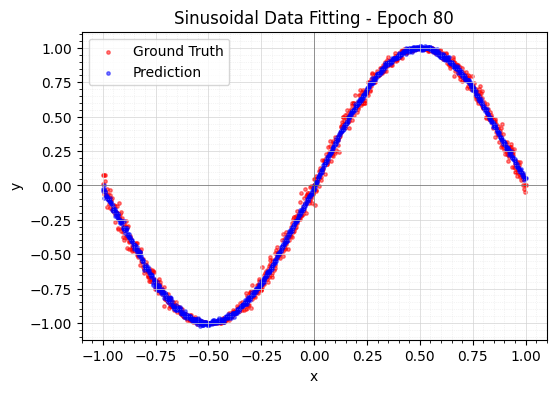

Epoch 80/100, MSE: 0.001316
Epoch 81/100, MSE: 0.001365
Epoch 82/100, MSE: 0.001319
Epoch 83/100, MSE: 0.001331
Epoch 84/100, MSE: 0.001338
Epoch 85/100, MSE: 0.001337
Epoch 86/100, MSE: 0.001354
Epoch 87/100, MSE: 0.001321
Epoch 88/100, MSE: 0.001321
Epoch 89/100, MSE: 0.001332


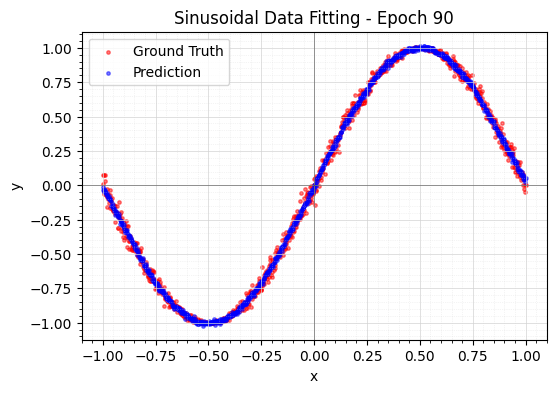

Epoch 90/100, MSE: 0.001317
Epoch 91/100, MSE: 0.001325
Epoch 92/100, MSE: 0.001331
Epoch 93/100, MSE: 0.001330
Epoch 94/100, MSE: 0.001300
Epoch 95/100, MSE: 0.001309
Epoch 96/100, MSE: 0.001333
Epoch 97/100, MSE: 0.001318
Epoch 98/100, MSE: 0.001340
Epoch 99/100, MSE: 0.001305


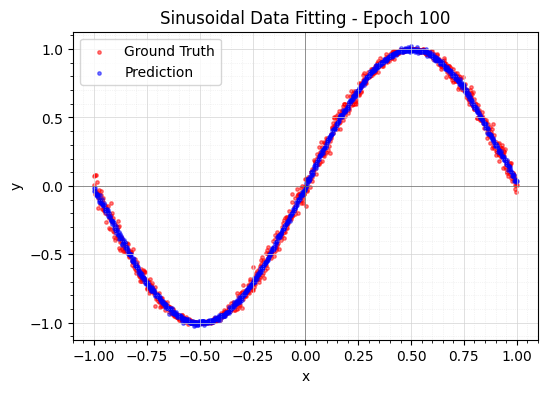

Epoch 100/100, MSE: 0.001346


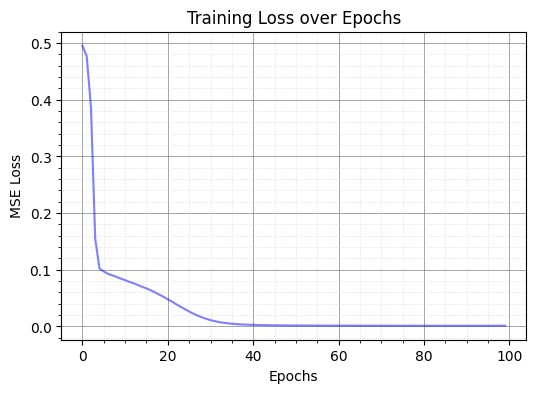

Training complete.


In [28]:
from utilities.data import generate_sinusoidal_data                 # Custom module for generating sinusoidal data
from utilities.visualization import plot_data_points, plot_series   # Custom module for visualizing 2D data

N               = 1000      # Number of data points  
EPOCHS          = 100       # Number of training epochs
LEARNING_RATE   = 0.01      # Learning Rate
BATCH_SIZE      = 4         # Batch size for training

# Generate sinusoidal data
X, Y = generate_sinusoidal_data(
    num_samples = N,
    noise       = 0.05
)

# plot data points
plot_data_points(X, Y)

model = NeuralNetwork(
    layers = [
        DenseLayer(input_size=1, output_size=20),
        ReLU(),
        DenseLayer(input_size=20, output_size=20),
        ReLU(),
        DenseLayer(input_size=20, output_size=20),
        ReLU(),
        DenseLayer(input_size=20, output_size=1),
    ]
)
loss_fn = MSELoss()

losses = []

for epoch in range(1, EPOCHS+1):
    loss_epoch = 0.
    indices = np.random.choice(range(N), N, replace=False)
    Y_hat = np.zeros_like(Y)

    for batch in range(0, N, BATCH_SIZE):
        batch_indices = indices[batch:batch + BATCH_SIZE]
        X_batch = X[batch_indices]
        Y_batch = Y[batch_indices]

        # Forward pass
        Y_hat_batch = model.forward(X_batch)

        # Compute loss
        loss = loss_fn.forward(Y_hat_batch, Y_batch)
        loss_epoch += loss

        # Backward pass
        grad_loss = loss_fn.backward(Y_hat_batch, Y_batch)
        model.backward(grad_loss, LEARNING_RATE)

        # store predictions
        Y_hat[batch_indices] = Y_hat_batch
    loss_epoch /= (N / BATCH_SIZE)
    losses.append(loss_epoch)

    if epoch % 10 == 0 or epoch == 1 or epoch == EPOCHS:
        plot_data_points(input=X, target=Y, prediction=Y_hat, title=f"Sinusoidal Data Fitting - Epoch {epoch}")
    print(f"Epoch {epoch}/{EPOCHS}, MSE: {loss_epoch:0.6f}")

plot_series(data=losses, title="Training Loss over Epochs", xlabel="Epochs", ylabel="MSE Loss")
print("Training complete.")